In [2]:
# Import necessary libraries.
import os
import glob
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

Camera Calibration
===

In [3]:
# Create object points.
objp = np.zeros((9 * 6, 3), np.float32)
objp[:, :2] = np.mgrid[0:9, 0:6].T.reshape(-1, 2)

# Lists to store object points and images points.
objpoints = [] # 3d points in real space.
imgpoints = [] # 2d points in image plane.

# Make a list of all images paths.
images = glob.glob('camera_cal/*.jpg')

# Cycle through each image to find corners points.
for fname in images:
    # Read image.
    img = cv2.imread(fname)
    # Graysclae.
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    # Find chessboard corners.
    ret, corners = cv2.findChessboardCorners(gray, (9, 6))
    
    # If corners are detected.
    if ret:
        objpoints.append(objp)
        imgpoints.append(corners)
        
        # Draw images with detected corners.
        cv2.drawChessboardCorners(img, (9, 6), corners, ret)
        cv2.imshow('img', img)
        cv2.waitKey(250)
        
cv2.destroyAllWindows()

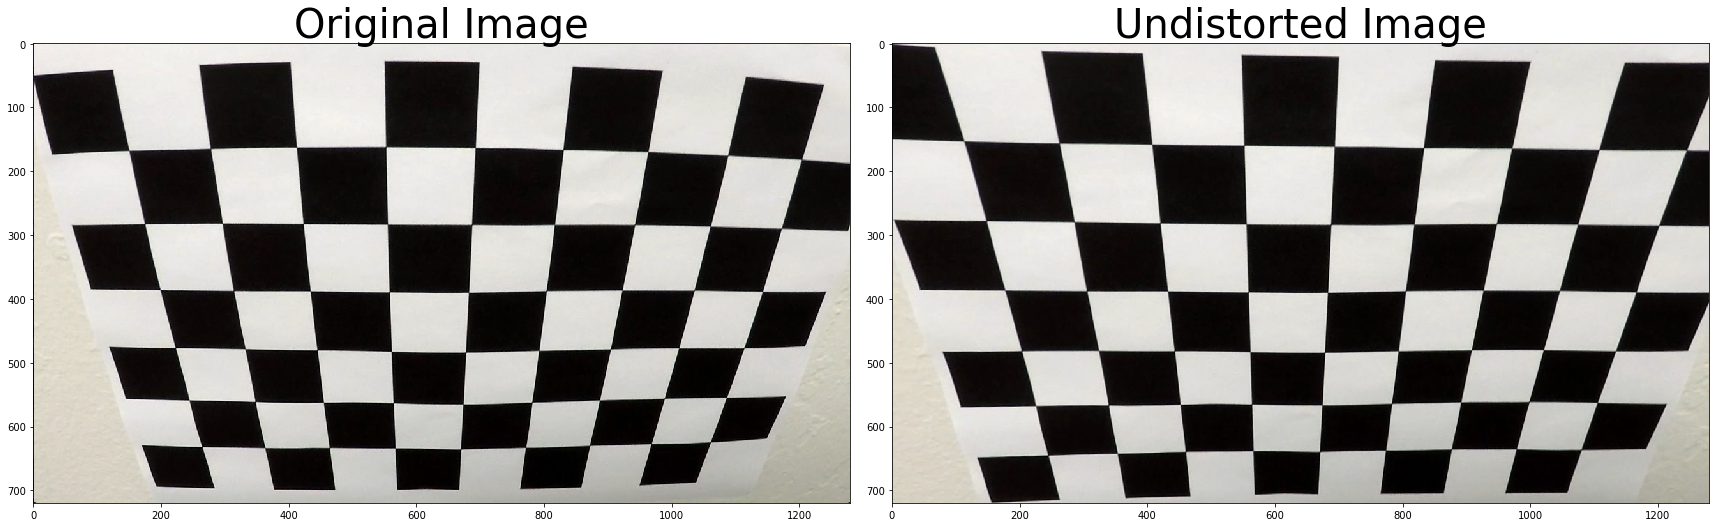

In [4]:
# Define a function to calibrate camera and undistort images.
def cal_undistort(img, objpoints, imgpoints): # img has to be of the same shape as the chessboard images??
    ret, intrmtx, distcoeff, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img.shape[1::-1], None, None)
    undistorted = cv2.undistort(img, intrmtx, distcoeff)
    return undistorted

# Test cal_undistort function.
img = mpimg.imread('camera_cal/test.jpg')
undistorted = cal_undistort(img, objpoints, imgpoints)

# Plot the original and the undistorted images side by side.
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=40)
ax2.imshow(undistorted)
ax2.set_title('Undistorted Image', fontsize=40)
f.savefig('output_images/checker_original_v_undistorted.jpg')

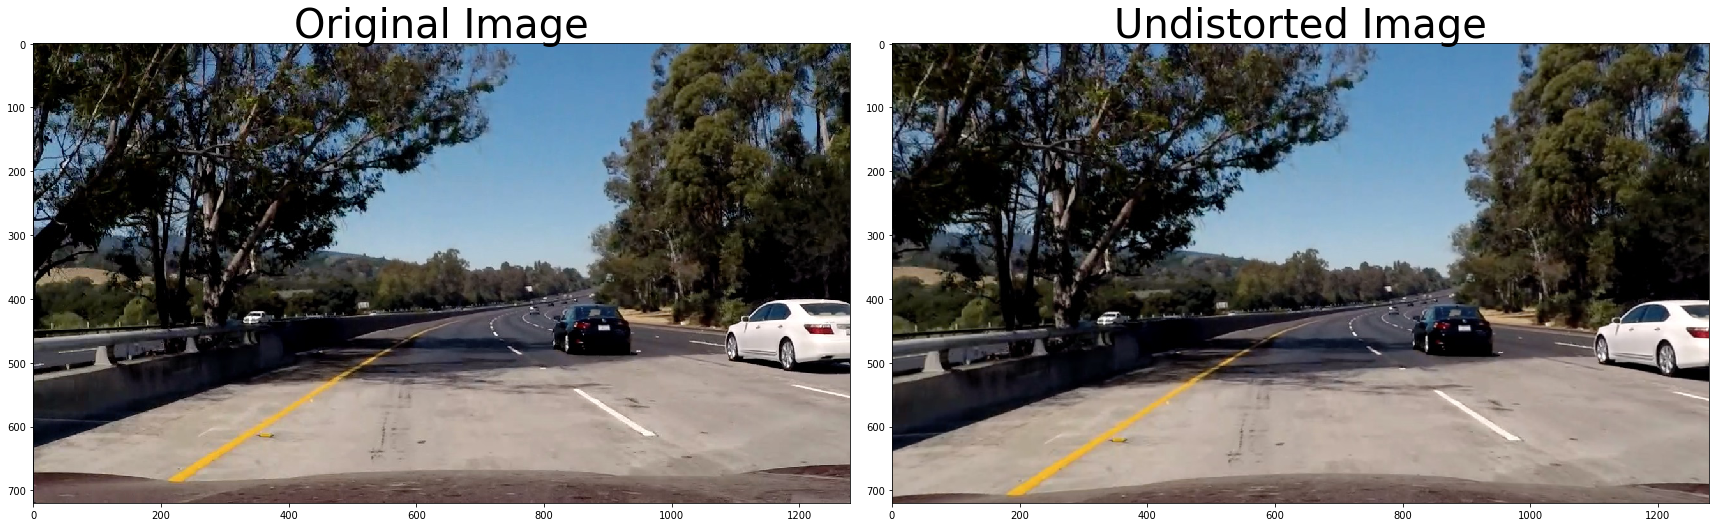

In [5]:
# Test cal_undistort function on road image.
img = mpimg.imread('test_images/test5.jpg')
undistorted = cal_undistort(img, objpoints, imgpoints)

# Plot the original and the undistorted images side by side.
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=40)
ax2.imshow(undistorted)
ax2.set_title('Undistorted Image', fontsize=40)
f.savefig('output_images/road_original_v_undistorted.jpg')

Image Thresholding
===

In [6]:
# Define a function to apply x or y gradient absolute value thresholds.   
def abs_thresh(img, orient='x', thresh=(20, 255), kernel=3):
    # Derive the gradient.
    if orient=='x':
        grad = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=kernel)
    elif orient=='y':
        grad = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=kernel)
    # Absolute value.
    abs = np.absolute(grad)
    # Scale the output to a (0 to 255) 8-bit single channel image.
    scaled = np.uint8(abs / np.amax(abs) * 255)
    # Apply thresholds.
    binary = np.zeros_like(scaled)
    binary[(scaled >= thresh[0]) & (scaled <= thresh[1])] = 1
    return binary

# Define a function to apply gradient magnitude thresholds.  
def mag_thresh(img, thresh=(20, 255), kernel=3):
    # Derive the gradients.
    xgrad = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=kernel)
    ygrad = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=kernel)
    # Calculate magnitude.
    mag = (xgrad ** 2 + ygrad ** 2) ** 0.5
    # Scale the output to a (0 to 255) 8-bit single channel image.
    scaled = np.uint8(mag / np.amax(mag) * 255)
    # Apply thresholds.
    binary = np.zeros_like(scaled)
    binary[(scaled >= thresh[0]) & (scaled <= thresh[1])] = 1
    return binary

# Define a function to apply gradient direction thresholds.
def dir_thresh(img, thresh=(0.85, 1.1), kernel=3):
    # Derive the gradients.
    xgrad = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=kernel)
    ygrad = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=kernel)
    # Absolute values.
    xabs = np.absolute(xgrad)
    yabs = np.absolute(ygrad)
    # Calculate angles in radians.
    radian = np.arctan2(yabs, xabs)
    # Apply thresholds.
    binary = np.zeros_like(np.uint8(radian))
    binary[(radian >= thresh[0]) & (radian <= thresh[1])] = 1
    return binary

In [7]:
# Define a function to add gaussian blur.
def gaussian(img):
    blurred = cv2.GaussianBlur(img, (3, 3), 0)
    return blurred

# Convert to grayscale.
gray = cv2.cvtColor(undistorted, cv2.COLOR_RGB2GRAY)

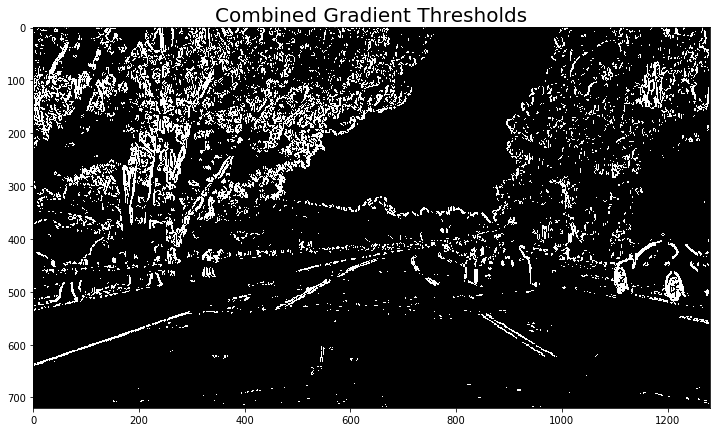

In [8]:
# Test the gradient thresholding functions.
kernel = 5
gradx_th = (30, 255)
grady_th = (30, 255)
mag_th = (30, 255)
dir_th = (1.0, 1.4)
gradx_binary = gaussian(abs_thresh(gray, orient='x', thresh=gradx_th, kernel=kernel))
grady_binary = gaussian(abs_thresh(gray, orient='y', thresh=grady_th, kernel=kernel))
mag_binary = gaussian(mag_thresh(gray, thresh=mag_th, kernel=kernel))
dir_binary = gaussian(dir_thresh(gray, thresh=dir_th, kernel=kernel))
  
# Combine information from all the gradient binary images.
gradcombined = np.zeros_like(gray)
gradcombined[(gradx_binary == 1) | ((mag_binary == 1) & (dir_binary == 1))] = 1

# Plot gradient combined binary image.
plt.figure(figsize=(14, 7))
plt.imshow(gradcombined, cmap='gray')
plt.title('Combined Gradient Thresholds', fontsize=20)

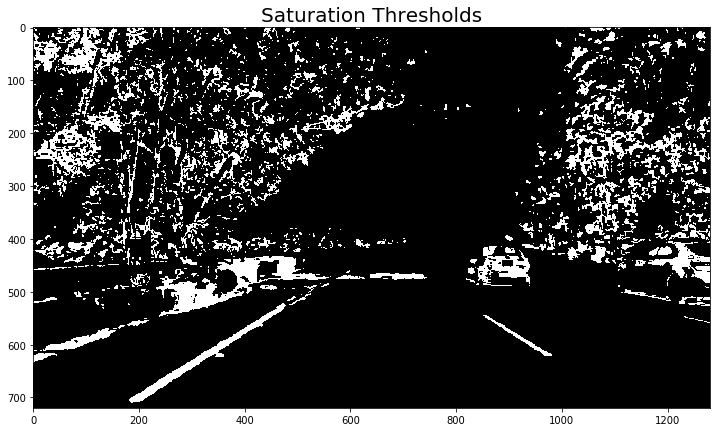

In [9]:
# Define a function to apply saturation thresholds.
def sat_thresh(img, thresh=(50, 255)):
    # Convert to HLS Colorspace.
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    # Separate hue channel.
    sat = hls[:, :, 2]
    # Apply thresholds.
    binary = np.zeros_like(sat)
    binary[(sat >= thresh[0]) & (sat <= thresh[1])] = 1
    return binary

# Test the hue thresholding function.
sat_th = (120, 255)
sat_binary = gaussian(sat_thresh(undistorted, thresh=sat_th))

# Plot hue binary image.
plt.figure(figsize=(14,7))
plt.imshow(sat_binary, cmap='gray')
plt.title('Saturation Thresholds', fontsize=20)

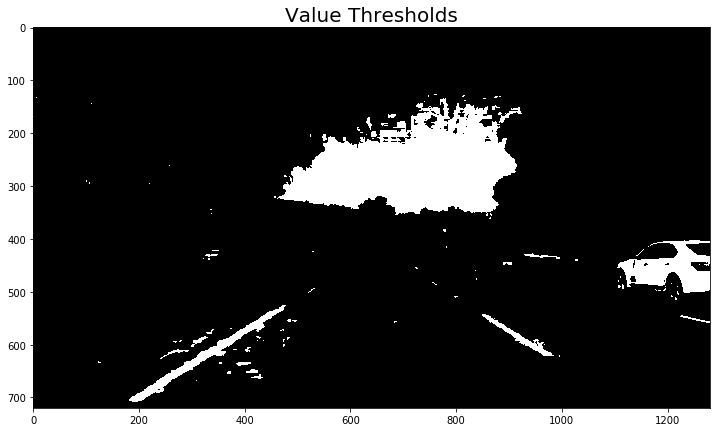

In [10]:
# Define a function to apply value thresholds.   
def value_thresh(img, thresh=(50, 255)):
    # Convert to HSV Colorspace.
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    # Separate value channel.
    value = hsv[:, :, 2]
    # Apply thresholds.
    binary = np.zeros_like(value)
    binary[(value >= thresh[0]) & (value <= thresh[1])] = 1
    return binary

# Test the saturation thresholding function.
value_th = (200, 255)
value_binary = gaussian(value_thresh(undistorted, thresh=value_th))

# Plot value binary image.
plt.figure(figsize=(14,7))
plt.imshow(value_binary, cmap='gray')
plt.title('Value Thresholds', fontsize=20)

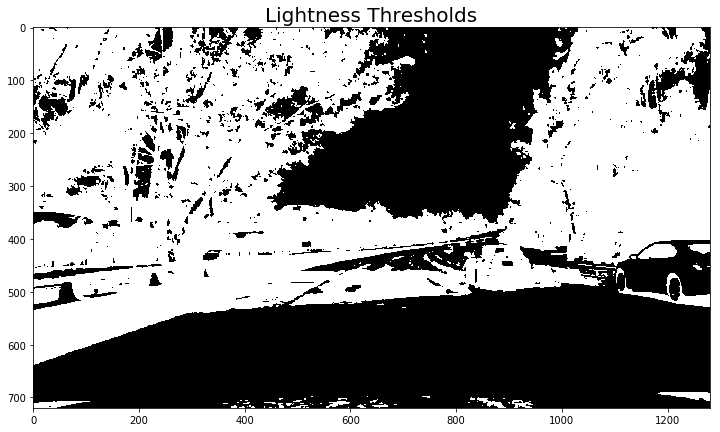

In [11]:
# Define a function to apply lightness thresholds to deselect dark pixels from the binary image.
def light_thresh(img, thresh=(50, 255)):
    # Convert to HSV Colorspace.
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    # Separate value channel.
    light = hls[:, :, 1]
    # Apply thresholds.
    binary = np.zeros_like(light)
    binary[(light >= thresh[0]) & (light <= thresh[1])] = 1
    return binary

# Test the saturation thresholding function.
light_th = (0, 80)
light_binary = gaussian(light_thresh(undistorted, thresh=light_th))

# Plot value binary image.
plt.figure(figsize=(14,7))
plt.imshow(light_binary, cmap='gray')
plt.title('Lightness Thresholds', fontsize=20)

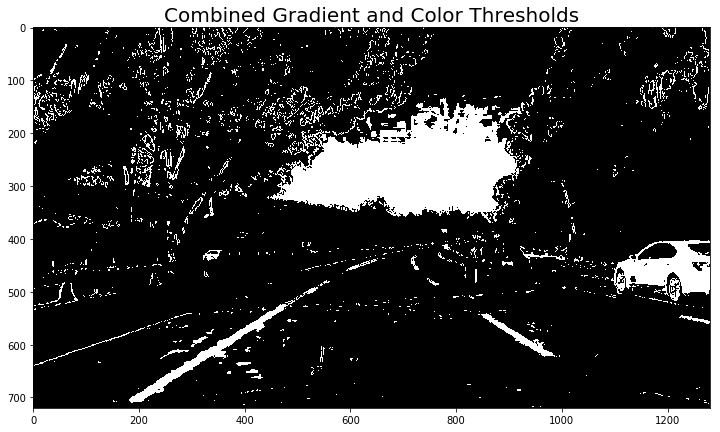

In [12]:
#### Combine information from the combined gradient, hue and value binary images.
combined = np.zeros_like(gradcombined)
combined[((gradcombined == 1) | (sat_binary == 1) | (value_binary == 1)) & (light_binary != 1)] = 1

# Plot combined binary image.
plt.figure(figsize=(14,7))
plt.imshow(combined, cmap='gray')
plt.title('Combined Gradient and Color Thresholds', fontsize=20)
plt.savefig('output_images/combined_binary_example.jpg')

Image Masking
===

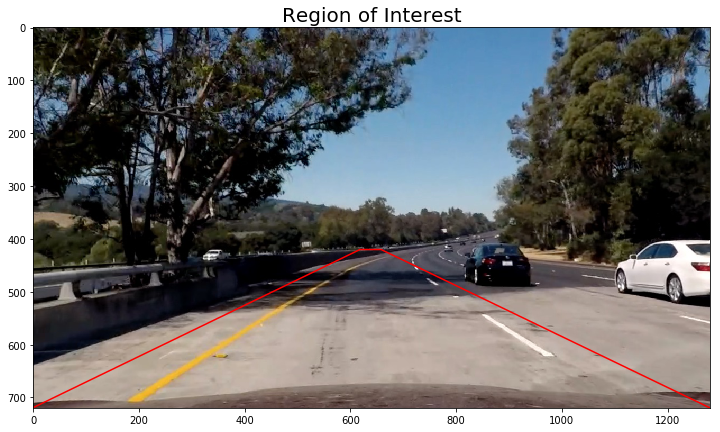

In [118]:
# Define region of interest points.
region = np.int32([[[0, 719],
                  [618, 420],
                  [658, 420],
                  [1279, 719]]])

# Plot selected destination points.
plt.figure(figsize=(14,7))
plt.imshow(undistorted)
plt.plot(region.T[0], region.T[1], 'r')
plt.title('Region of Interest', fontsize=20)

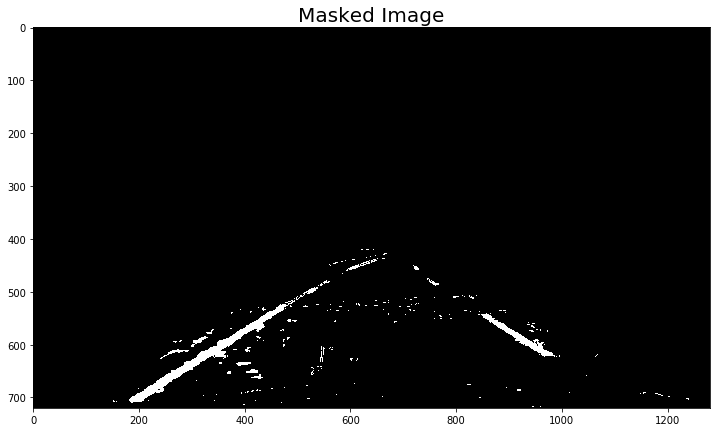

In [132]:
# Define a function to mask portions of the image outside the region of interest.
def mask(combined, region):
    mask = np.zeros_like(combined)
    cv2.fillPoly(mask, region, 255) # Fill the region of interest with maximum value.
    masked_image = cv2.bitwise_and(combined, mask)
    return masked_image

# Test masking function.
masked_image = mask(combined, region)

# Plot masked image.
plt.figure(figsize=(14,7))
plt.imshow(masked_image, cmap='gray')
plt.title('Masked Image', fontsize=20)
plt.savefig('output_images/mask.jpg')

Perspective Warping
===

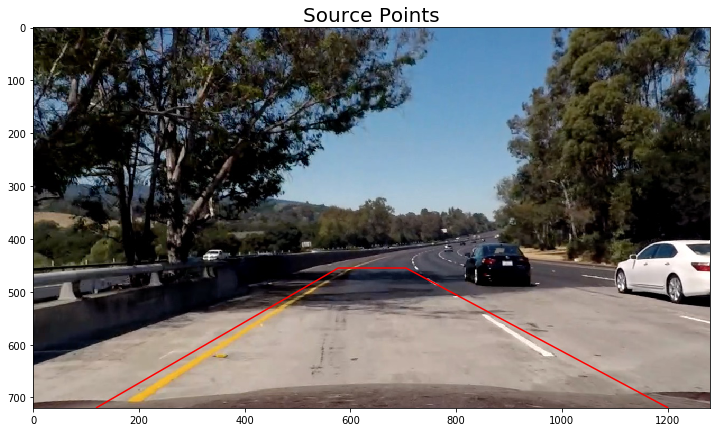

In [133]:
# Define source points for perspective warping.
src = np.float32([[120, 719],
                  [577, 455],
                  [705, 455],
                  [1200, 719]])

# Plot selected source points.
plt.figure(figsize=(14,7))
plt.imshow(undistorted)
plt.plot(src.T[0], src.T[1], 'r')
plt.title('Source Points', fontsize=20)
plt.savefig('output_images/undistorted_src_points.jpg')

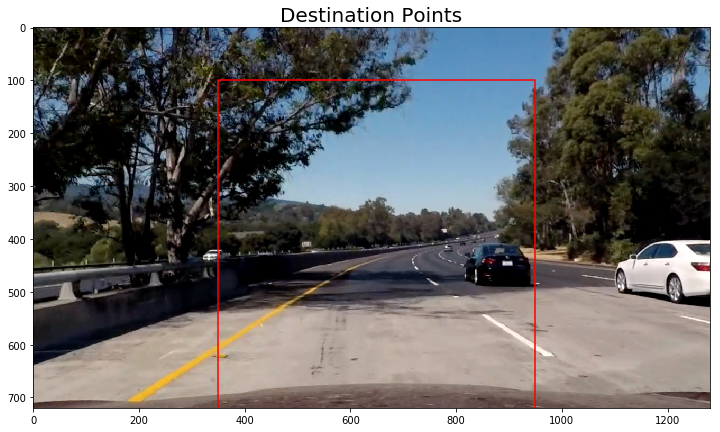

In [134]:
# Define destination points for perspective warping.
dst = np.float32([[350, 719],
                  [350, 100],
                  [950, 100],
                  [950, 719]])

# Plot selected destination points.
plt.figure(figsize=(14,7))
plt.imshow(undistorted)
plt.plot(dst.T[0], dst.T[1], 'r')
plt.title('Destination Points', fontsize=20)

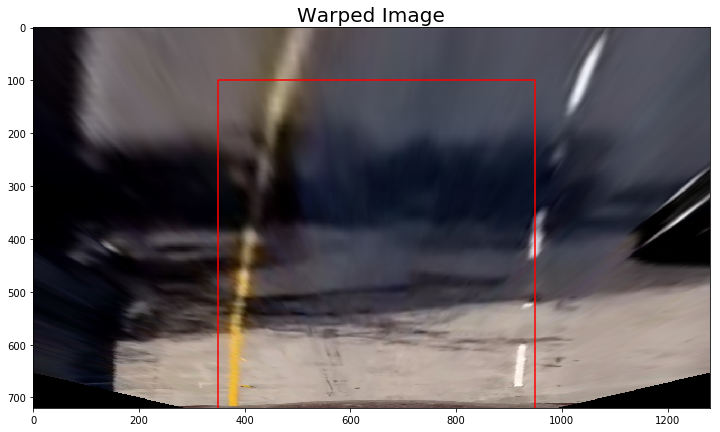

In [135]:
# Define a function to warp prespective to a bird's eye view.
def bird_eye(img, src, dst):
    # Compute the perspective transform matrix.
    M = cv2.getPerspectiveTransform(src, dst)
    # Compute the inverse transform matrix.
    Minv = cv2.getPerspectiveTransform(dst, src)
    # Warp image.
    warped = cv2.warpPerspective(img, M, img.shape[1::-1], flags=cv2.INTER_LINEAR)
    return warped

# Test the bird's eye view function on the undistorted image
warped = bird_eye(undistorted, src, dst)

# Plot the bird's eye view image.
plt.figure(figsize=(14,7))
plt.imshow(warped, cmap='gray')
plt.title('Warped Image', fontsize=20)
plt.plot(dst.T[0], dst.T[1], 'r')
plt.savefig('output_images/warped_dst_points.jpg')

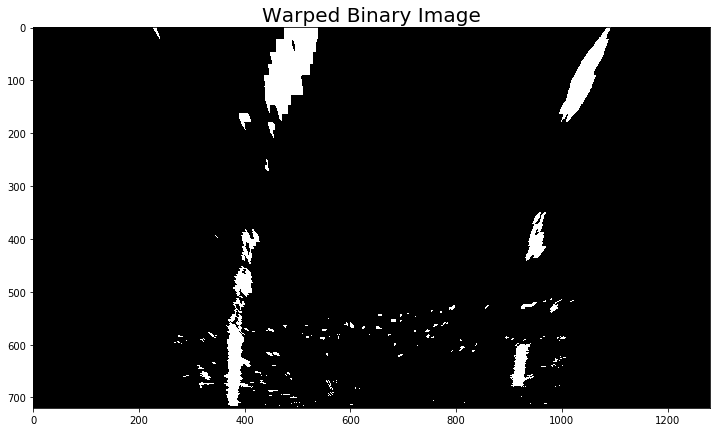

In [136]:
# Test the bird's eye view function on the masked image.
warped = bird_eye(masked_image, src, dst)

# Plot the bird's eye view image.
plt.figure(figsize=(14,7))
plt.imshow(warped, cmap='gray')
plt.title('Warped Binary Image', fontsize=20)

Finding Lane Lines
===

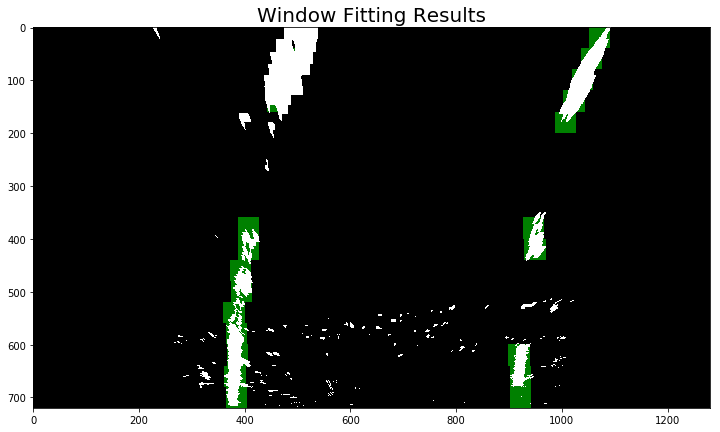

In [137]:
# Define a function to mask a window of given size and position.
def window_mask(width, height, img, center, level):
    output = np.zeros_like(img)
    if center is None:
        return output # Return empty image.
    output[int(img.shape[0] - (level + 1) * height):int(img.shape[0] - level * height), max(0, int(center - width / 2)):min(int(center + width / 2), img.shape[1])] = 1
    return output

# Define a function to return the x-positions of the windows centroids.
def find_window_centroids(img, window_width, window_height, window_margin):    
    window_centroids = [] # Store the (left,right) window centroid positions per level
    window = np.ones(window_width) # Create our window template that we will use for convolutions
  
    # First find the two starting positions for the left and right lane by using np.sum to get the vertical image slice
    # and then np.convolve the vertical image slice with the window template.
    
    # Sum lowest portion of image to get slice.
    l_sum = np.sum(img[int(14 * img.shape[0] / 18):, :int(img.shape[1] / 2)], axis=0)
    l_centroid = np.argmax(np.convolve(window, l_sum)) - window_width / 2
    r_sum = np.sum(img[int(14 * img.shape[0] / 18):, int(img.shape[1] / 2):], axis=0)
    r_centroid = np.argmax(np.convolve(window, r_sum)) - window_width / 2 + int(img.shape[1] / 2)
    
    # Add what we found for the first layer.
    window_centroids.append((l_centroid, r_centroid))

    # Go through each layer looking for max pixel locations.
    for level in range(1, int(img.shape[0] / window_height)):
        # convolve the window into the vertical slice of the image
        image_layer = np.sum(img[int(img.shape[0] - (level + 1) * window_height):int(img.shape[0] - level * window_height), :], axis=0)
        conv_signal = np.convolve(window, image_layer)
        # Find the best left centroid by using past left center as a reference
        # Use window_width/2 as offset because convolution signal reference is at right side of window, not center of window
        offset = window_width / 2
        l_min_index = int(max(l_centroid + offset - window_margin, 0))
        l_max_index = int(min(l_centroid + offset + window_margin, img.shape[1]))
        l_centroid_new = np.argmax(conv_signal[l_min_index:l_max_index]) + l_min_index - offset
        # Find the best right centroid by using past right center as a reference
        r_min_index = int(max(r_centroid + offset - window_margin, 0))
        r_max_index = int(min(r_centroid + offset + window_margin, img.shape[1]))
        r_centroid_new = np.argmax(conv_signal[r_min_index:r_max_index]) + r_min_index - offset
        # Check for a minimum number of nonzero pixels.
        if conv_signal[int(l_centroid_new)] >= pixel_thresh: # If pixel threshold is excedeed.
            l_centroid = l_centroid_new # Update reference point.
        else:
            l_centroid_new = None # Don't update reference point and consider the newly found point as None.
        if conv_signal[int(r_centroid_new)] >= pixel_thresh: # If pixel threshold is excedeed.
            r_centroid = r_centroid_new # Update reference point.
        else:
            r_centroid_new = None # Don't update reference point and consider the newly found point as None.
        window_centroids.append((l_centroid_new, r_centroid_new))
    return window_centroids

# Test window centroids function.
# Window settings.
window_width = 40 # Search window width.
window_height = 40 # Search window height.
window_margin = 100 # Search window margin.
pixel_thresh = 100 # Pixel threshold above which to consider a lane line window found.
window_centroids = find_window_centroids(warped, window_width, window_height, window_margin)

# If we found any window centers.
if (len(window_centroids) > 0):
    # Points used to draw all the left and right windows.
    l_points = np.zeros_like(warped)
    r_points = np.zeros_like(warped)

    # Go through each level and draw the windows.
    for level in range(0, len(window_centroids)):
        l_mask = window_mask(window_width, window_height, warped, window_centroids[level][0], level)
        r_mask = window_mask(window_width, window_height, warped, window_centroids[level][1], level)
        # Add graphic points from window mask to total pixels found.
        l_points[(l_points == 255) | ((l_mask == 1))] = 255
        r_points[(r_points == 255) | ((r_mask == 1))] = 255

    # Draw the results
    template = np.array(r_points + l_points, np.uint8) # Add both left and right window pixels together.
    zero_channel = np.zeros_like(template) # Create a zero color channel.
    template = np.array(cv2.merge((zero_channel, template, zero_channel)), np.uint8) # Make window pixels green.
    warpage= np.dstack((warped, warped, warped)) * 255 # Making the original road pixels 3 color channels.
    output = cv2.addWeighted(warpage, 1.0, template, 0.5, 0.0) # Overlay the orignal road image with window results.

# If no window centers found, just display orginal road image.
else:
    output = np.array(cv2.merge((warped, warped, warped)), np.uint8)

# Plot the detected windows.
plt.figure(figsize=(14, 7))
plt.imshow(output)
plt.title('Window Fitting Results', fontsize=20)

In [138]:
# Define a function to get the x & y coordinates of the windows centroids.
def get_coordinates(img, window_height, centroids):
    lefty, leftx, righty, rightx = [], [], [], []
    for level in range(0, int(img.shape[0] / window_height)):
        centroids_inv = centroids[::-1] # Invert array to get x coordinates from top to bottom.

        lefty_val = (level + 1) * window_height - window_height / 2
        leftx_val = centroids_inv[level][0]
        righty_val = (level + 1) * window_height - window_height / 2
        rightx_val = centroids_inv[level][1]
        
        if leftx_val != None:
            lefty.append(lefty_val)
            leftx.append(leftx_val)
        if rightx_val != None:
            righty.append(righty_val)
            rightx.append(rightx_val)
    return np.array(lefty), np.array(leftx), np.array(righty), np.array(rightx)

# Test coordinates function.
lefty, leftx, righty, rightx = get_coordinates(warped, window_height, window_centroids)

# Fit second degree polynomials to the windows centers.
left_fit = np.polyfit(lefty, leftx, 2)
right_fit = np.polyfit(righty, rightx, 2)

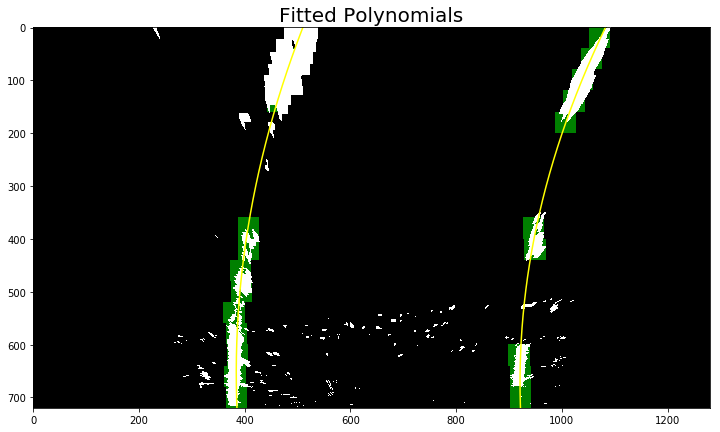

In [139]:
# Generate x and y values for plotting
ploty = np.linspace(0, warped.shape[0] - 1, warped.shape[0])
left_fitx = left_fit[0] * ploty ** 2 + left_fit[1] * ploty + left_fit[2]
right_fitx = right_fit[0] * ploty ** 2 + right_fit[1] * ploty + right_fit[2]

# Plot polynomials.
plt.figure(figsize=(14, 7))
plt.imshow(output)
plt.title('Fitted Polynomials', fontsize=20)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.savefig('output_images/fit_poly.jpg')

In [140]:
# Define a function to return the nonzero points around the fitted polynomials.
# Will be used as a second detection algorithm after the lane lines are initially detected.
def nonzero_polylines(warped, left_fit, right_fit, poly_margin):
    nonzero = warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])

    left_lane_inds = ((nonzerox > (left_fit[0] * (nonzeroy ** 2) + left_fit[1] * nonzeroy + 
    left_fit[2] - poly_margin)) & (nonzerox < (left_fit[0] * (nonzeroy ** 2) + 
    left_fit[1] * nonzeroy + left_fit[2] + poly_margin))) 

    right_lane_inds = ((nonzerox > (right_fit[0] * (nonzeroy ** 2) + right_fit[1] * nonzeroy + 
    right_fit[2] - poly_margin)) & (nonzerox < (right_fit[0] * (nonzeroy ** 2) + 
    right_fit[1] * nonzeroy + right_fit[2] + poly_margin)))

    return nonzeroy[left_lane_inds], nonzerox[left_lane_inds], nonzeroy[right_lane_inds], nonzerox[right_lane_inds]

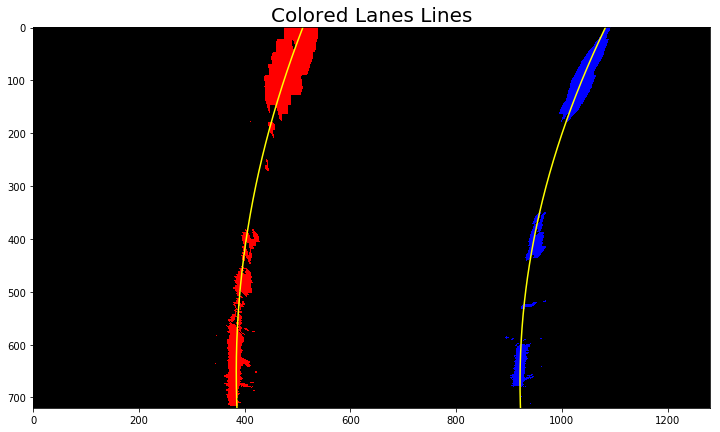

In [141]:
# Define a function to color the lane lines pixels around the fitted polynomials.
def color_lines(warped, left_fit, right_fit, poly_margin):
    # Get the nonzero points around the polynomials.
    nonzeroy_left, nonzerox_left, nonzeroy_right, nonzerox_right = nonzero_polylines(warped, left_fit, right_fit, poly_margin)

    # Create an empty image to draw on the colored pixels.
    empty = np.zeros_like(warped)
    out_img = np.dstack((empty, empty, empty)) * 255
    # Color in left and right line pixels.
    out_img[nonzeroy_left, nonzerox_left] = [255, 0, 0]
    out_img[nonzeroy_right, nonzerox_right] = [0, 0, 255]
    return out_img

# Test line coloring function.
poly_margin = 40
out_img = color_lines(warped, left_fit, right_fit, poly_margin)

# Plot polynomials with lane lines pixels colored.
plt.figure(figsize=(14, 7))
plt.imshow(out_img)
plt.title('Colored Lanes Lines', fontsize=20)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')

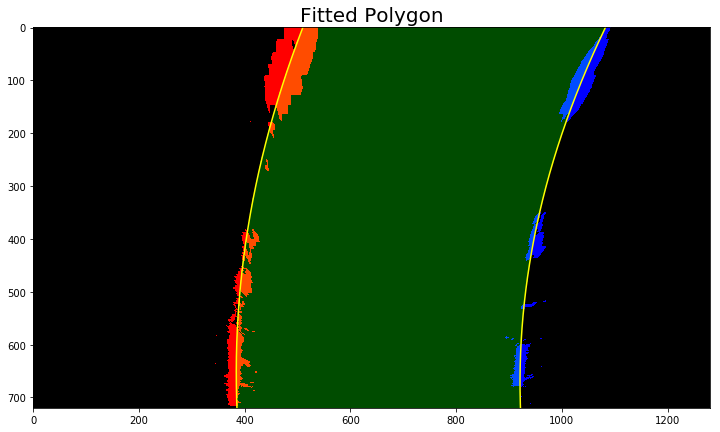

In [142]:
# Define a function to highlight the lane.
def highlight_lane(out_img, ploty, left_fitx, right_fitx):
    window_img = np.zeros_like(out_img)

    # Generate a polygon around the two lane lines polynomials.
    left_line_pts = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    right_line_pts = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    polygon_pts = np.hstack((left_line_pts, right_line_pts))

    # Draw the lane polygon onto the warped blank image.
    cv2.fillPoly(window_img, np.int_([polygon_pts]), (0,255, 0))
    highlight = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    return highlight

# Test lane highlighting function.
highlight = highlight_lane(out_img, ploty, left_fitx, right_fitx)

# Plot highlighted lane.
plt.figure(figsize=(14, 7))
plt.imshow(highlight)
plt.title('Fitted Polygon', fontsize=20)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')

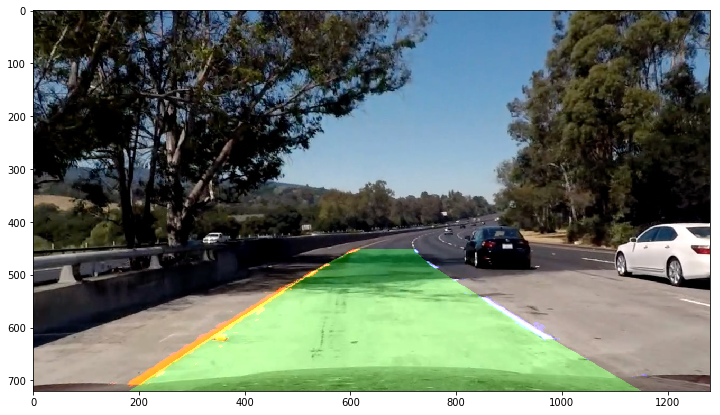

In [143]:
# Warp the image back to the original perspective.
warped_back = bird_eye(highlight, dst, src)

# Plot the original image with the lane and lane lines highlighted.
highlighted_lane = cv2.addWeighted(undistorted, 1, warped_back, 1, 0)
plt.figure(figsize=(14, 7))
plt.imshow(highlighted_lane)
plt.savefig('output_images/highlighted_lane.jpg')

In [144]:
# Define a function to calculate radius of curvature in pixles.
def curverad(left_fit, right_fit, y_eval):
    left_curverad = ((1 + (2 * left_fit[0] * y_eval + left_fit[1]) ** 2) ** 1.5) / np.absolute(2 * left_fit[0])
    right_curverad = ((1 + (2 * right_fit[0] * y_eval + right_fit[1]) ** 2) ** 1.5) / np.absolute(2 * right_fit[0])
    return left_curverad, right_curverad

# Test radius of curvature function.
# Define y-value where we want radius of curvature.
y_eval = np.max(ploty) # Bottom of the image.
left_curverad, right_curverad = curverad(left_fit, right_fit, y_eval)
print(left_curverad)
print(right_curverad)

1697.7617843962526
1397.527782211492


In [145]:
# Define a function to calculate radius of curvature in meters:
def curverad_mtrs(lefty, leftx, righty, rightx, ym, xm, y_eval):
    # Fit new polynomials to x,y in world space.
    left_fit_cr = np.polyfit(lefty * ym, leftx * xm, 2)
    right_fit_cr = np.polyfit(righty * ym, rightx * xm, 2)
    # Calculate the new radii of curvature.
    left_curverad = ((1 + (2 * left_fit_cr[0] * y_eval * ym + left_fit_cr[1]) ** 2) ** 1.5) / np.absolute(2 * left_fit_cr[0])
    right_curverad = ((1 + (2 * right_fit_cr[0] * y_eval * ym + right_fit_cr[1]) ** 2) ** 1.5) / np.absolute(2 * right_fit_cr[0])
    return left_curverad, right_curverad

# Test radius of curvature in meters function.
# Define conversions in x and y from pixels space to meters
ym = 30 / 720 # meters per pixel in y dimension
xm = 3.7 / 700 # meters per pixel in x dimension
left_curverad, right_curverad = curverad_mtrs(lefty, leftx, righty, rightx, ym, xm, y_eval)
average = np.average((left_curverad, right_curverad))

print("Left Radius: {:.2f}m, Right Radius: {:.2f}m".format(left_curverad, right_curverad))
print("Average Radius: {:.2f}m".format(average))

Left Radius: 556.39m, Right Radius: 458.24m
Average Radius: 507.31m


In [146]:
# Define a function to calculate offset from the center of the lane in meters.
def offset_mtrs(left_fitx, right_fitx, warped, xm, y_eval):
    l_pos = left_fitx[int(y_eval)] # Left line x-position at the bottom of the image.
    r_pos = right_fitx[int(y_eval)] # Right line x-position at the bottom of the image.
    lane_center = ((r_pos - l_pos) / 2) + l_pos
    img_center = warped.shape[1] / 2
    offset = (img_center - lane_center) * xm
    return offset

# Test offset function.
offset = offset_mtrs(left_fitx, right_fitx, warped, xm, y_eval)
if offset < 0:
    print("Vehicle is {:.2f}m left of center".format(np.absolute(offset)))
else:
    print("Vehicle is {:.2f}m right of center".format(np.absolute(offset)))

Vehicle is 0.07m left of center


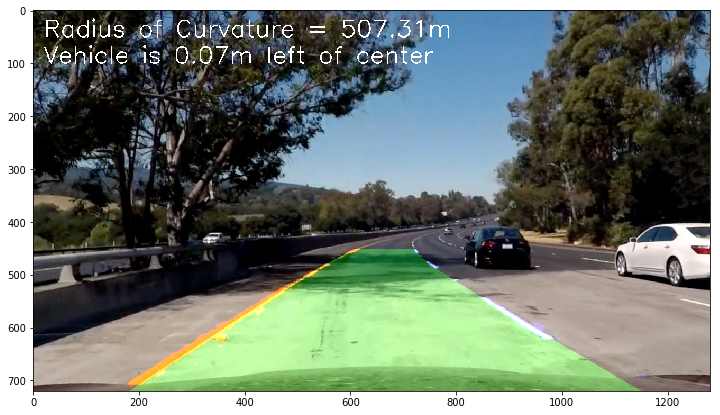

In [147]:
# Define a function to print text on image.
def print_text(highlighted_lane, string1, string2):
    texted_image = cv2.putText(np.copy(highlighted_lane), text=string1, org=(20, 50),fontFace=0, fontScale=1.5, color=(255, 255, 255), thickness=2)
    texted_image = cv2.putText(texted_image, text=string2, org=(20, 100),fontFace=0, fontScale=1.5, color=(255, 255, 255), thickness=2)
    return texted_image

# Test print text function.
string1 = "Radius of Curvature = {:.2f}m".format(average)

if offset < 0:
    string2 = "Vehicle is {:.2f}m left of center".format(np.absolute(offset))
else:
    string2 = "Vehicle is {:.2f}m right of center".format(np.absolute(offset))
texted_image = print_text(highlighted_lane, string1, string2)

# Plot texted image.
plt.figure(figsize=(14, 7))
plt.imshow(texted_image)

Creating the Pipeline
===

In [148]:
# Define a class to receive the characteristics of each detected line.
class Line():
    def __init__(self):
        # Have we permanently lost track of the lane lines?
        self.lost = True
        # Number of failed detections.
        self.failed_count = 0
        # Polynomial coefficients for the most recent fit.
        self.current_fit = None
        # X values for detected line windows or nonzero pixels.
        self.allx = None  
        # Y values for detected line windows or nonzero pixels.
        self.ally = None
        
# Create 2 instances of the class for the left and right lane lines.
left_line = Line()
right_line = Line()

In [149]:
# Define a function to confirm that the detected lines are valid.
def sanity_check(left_fit, right_fit, ploty):
    # Generate x values of the polynomials.
    left_fitx = left_fit[0] * ploty ** 2 + left_fit[1] * ploty + left_fit[2]
    right_fitx = right_fit[0] * ploty ** 2 + right_fit[1] * ploty + right_fit[2]
    # Check separation distiance at 10 equally spaced y-axis points.
    testy = np.linspace(0, ploty.shape[0] - 1, 10)
    for i in testy:
        if not (350 < right_fitx[int(i)] - left_fitx[int(i)] < 650): # Distance between the two lane lines is less than 350 or greater than 550 pixels.
            return False # Test failed.
    return True # Test passed.

# Test sanity check function.
valid = sanity_check(left_fit, right_fit, ploty)
print(valid)

True


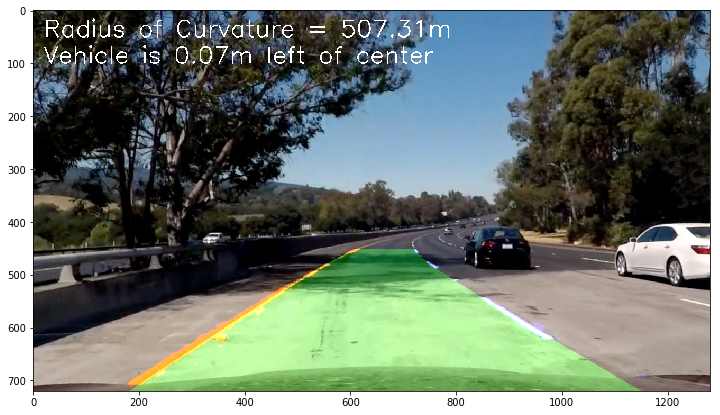

In [150]:
# Put everything together in a pipeline to be fed video frames.
def pipeline(img):    
    # Undistort image.
    undistorted = cal_undistort(img, objpoints, imgpoints)
    
    # Convert to grayscale.
    gray = cv2.cvtColor(undistorted, cv2.COLOR_RGB2GRAY)
    
    # Calculate binary threshold images.   
    gradx_binary = gaussian(abs_thresh(gray, orient='x', thresh=gradx_th, kernel=kernel))
    mag_binary = gaussian(mag_thresh(gray, thresh=mag_th, kernel=kernel))
    dir_binary = gaussian(dir_thresh(gray, thresh=dir_th, kernel=kernel))
    sat_binary = gaussian(sat_thresh(undistorted, thresh=sat_th))
    value_binary = gaussian(value_thresh(undistorted, thresh=value_th))
    light_binary = gaussian(light_thresh(undistorted, thresh=light_th))
    
    # Combine all binary threshold images.
    gradcombined = np.zeros_like(gray)
    combined = np.zeros_like(gray)
    gradcombined[(gradx_binary == 1) | ((mag_binary == 1) & (dir_binary == 1))] = 1
    combined[((gradcombined == 1) | (sat_binary == 1) | (value_binary == 1)) & (light_binary != 1)] = 1
    
    # Mask region of interest.
    masked_image = mask(combined, region)
    
    # Warp to bird's eye view.
    warped = bird_eye(masked_image, src, dst)
    
    if left_line.lost is True: # We lost track of the lines, start searching from scratch.
        # Find the x-positions of the windows centroids.
        window_centroids = find_window_centroids(warped, window_width, window_height, window_margin)
    
        # Get the x & y coordinates of the windows centroids.
        lefty, leftx, righty, rightx = get_coordinates(warped, window_height, window_centroids)
    
        # Fit polynomials.
        left_fit = np.polyfit(lefty, leftx, 2)
        right_fit = np.polyfit(righty, rightx, 2)
        
    else: # We can still use the search around polynomials method.
        # Get nonzero pixels around the polynomials.
        lefty, leftx, righty, rightx = nonzero_polylines(warped, left_line.current_fit, right_line.current_fit, poly_margin)
        
        # Fit polynomials.
        left_fit = np.polyfit(lefty, leftx, 2)
        right_fit = np.polyfit(righty, rightx, 2)
    
    # Generate y values.
    ploty = np.linspace(0, warped.shape[0] - 1, warped.shape[0])
    
    # Perform sanity check.
    if sanity_check(left_fit, right_fit, ploty): # Check passed.
        left_line.current_fit = left_fit
        right_line.current_fit = right_fit
        left_line.ally = lefty
        left_line.allx = leftx
        right_line.ally = righty
        right_line.allx = rightx
        left_line.failed_count = 0 # Reset failed detections counter.
        right_line.failed_count = 0 # Reset failed detections counter.    
    else:
        if left_line.failed_count == 10: # 10 consecutive failed detections.
            left_line.lost = True # We have permanently lost the lane lines.
            right_line.lost = True # We have permanently lost the lane lines.
            left_line.failed_count = 0 # Reset failed detections counter.
            right_line.failed_count = 0 # Reset failed detections counter.
        else:   
            left_line.failed_count += 1 # Increment failed detections counter.
            right_line.failed_count += 1 # Increment failed detections counter.
    
    if left_line.current_fit is not None:
        # Generate x values of the polynomials.
        left_fitx = left_line.current_fit[0] * ploty ** 2 + left_line.current_fit[1] * ploty + left_line.current_fit[2]
        right_fitx = right_line.current_fit[0] * ploty ** 2 + right_line.current_fit[1] * ploty + right_line.current_fit[2]

        # Define a y-value at which to measure lines curvatures.
        y_eval = np.max(ploty)

        # Get lane lines curvature in meters.
        left_curverad, right_curverad = curverad_mtrs(left_line.ally, left_line.allx, right_line.ally, right_line.allx, ym, xm, y_eval)
        average = np.average((left_curverad, right_curverad))

        # Get vehicle offset in meters.
        offset = offset_mtrs(left_fitx, right_fitx, warped, xm, y_eval)

        # Color the lane lines pixels.
        out_img = color_lines(warped, left_line.current_fit, right_line.current_fit, poly_margin)

        # Highlight lane.
        highlight = highlight_lane(out_img, ploty, left_fitx, right_fitx)

        # Warp back to the original perspective.
        warped_back = bird_eye(highlight, dst, src)

        # combine the original image with the warped back highlight.
        highlighted_lane = cv2.addWeighted(undistorted, 1, warped_back, 1, 0)

        # Define strings that will be printed on output image.
        string1 = "Radius of Curvature = {:.2f}m".format(average)

        if offset < 0:
            string2 = "Vehicle is {:.2f}m left of center".format(np.absolute(offset))
        else:
            string2 = "Vehicle is {:.2f}m right of center".format(np.absolute(offset))

        # Print text on image.
        texted_image = print_text(highlighted_lane, string1, string2)
        return texted_image
    else:
        return img
    
# Test pipeline.
result = pipeline(img)

# Plot final result
plt.figure(figsize=(14, 7))
plt.imshow(result)

Test Pipeline on Videos
===

In [33]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [34]:
output = 'output.mp4'
raw_clip = VideoFileClip("project_video.mp4")
output_clip = raw_clip.fl_image(pipeline) #NOTE: this function expects color images!!
%time output_clip.write_videofile(output, audio=False)

[MoviePy] >>>> Building video output.mp4
[MoviePy] Writing video output.mp4


 99%|███████████████████████████████████████████████████████████████████████████████▏| 100/101 [01:37<00:00,  1.03it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output.mp4 

Wall time: 1min 38s


In [35]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output))

In [36]:
# Define a function to extract some images from a video.
def extract_frames(movie, times, imgdir):
    clip = VideoFileClip(movie)
    for t in times:
        imgpath = os.path.join(imgdir, '{}.jpg'.format(t))
        clip.save_frame(imgpath, t)

movie = "project_video.mp4"
imgdir = "difficult_images"
times = np.linspace(38, 40, 21)


extract_frames(movie, times, imgdir)